# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 

Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from tqdm.auto import tqdm

In [2]:
!nvidia-smi

Sat Apr  8 20:27:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:17:00.0 Off |                    0 |
|  0%   59C    P0   133W / 300W |      0MiB /  5067MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [3]:
# Transformations type : https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_train_1 = transforms.Compose([
    transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
    transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
    transforms.RandomRotation(10),     #Rotates the image to a specified angel
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
    transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
])
 
transform_train_2 = transforms.Compose([
    #transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=[32,32], padding=4),
    transforms.RandomRotation(degrees=(-10, 10)),
    #transforms.RandomAdjustSharpness(sharpness_factor=2),
    #transforms.RandomResizedCrop(size=(32, 32)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
])

In [4]:
transform_train = transform_train_2

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# transform = transforms.Compose([transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [6]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [7]:
testset, trainset

(Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomCrop(size=(32, 32), padding=4)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

## Data Preprocessing

In [8]:
BATCH_SIZE = 8
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

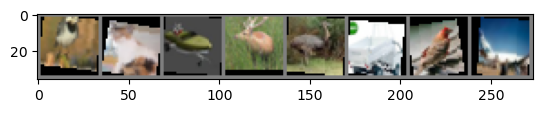

bird  cat   ship  deer  bird  truck bird  plane


In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


In [10]:
# print size of data in batch

for d in trainloader:
    print(d[0].shape)
    break

torch.Size([8, 3, 32, 32])


## Model

In [77]:
# Parameters 


N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

In [78]:
class ConvBlock(nn.Sequential):

    def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL):
        
        super(ConvBlock, self).__init__(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            #nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            #nn.Dropout2d(p=0.5),
        )

In [79]:
class Backbone(nn.Module):

    def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=False):
        super(Backbone, self).__init__()

        # Boolean to print debug logs.
        self.debug = debug

        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.linear = nn.Sequential(
            nn.Linear(in_features=in_channels, out_features=k, bias=False),   # Question, can this be MLP?
            #nn.Tanh(),
            # nn.LeakyReLU(),
            # nn.Linear(in_features=k, out_features=k, bias=True),  
            #nn.ReLU(),
            nn.Sigmoid(),      # Non Linear Activation
        )

        self.conv_blocks = nn.ModuleList([
            ConvBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
            for _ in range(k)
        ])

        self.batch_norm = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
        sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"{sap_out.shape=}")

        g_out = self.linear(sap_out)
        if self.debug: print(f"{g_out.shape=}")
        if self.debug: print(f"{g_out=}")

        outs = list()
        for a, conv_block in zip(g_out.transpose(0, 1), self.conv_blocks):
        #for conv2d in self.conv2ds:
            c_out = conv_block(x)
            if self.debug: print(f"{c_out.shape=}")
            if self.debug: print(f"{a.shape=}, \n{a=}")

            out = a.reshape(x.shape[0], 1, 1, 1)*c_out
            if self.debug: print(f"{out.shape=}")
            outs.append(out)
            #outs.append(c_out)

        out = sum(outs)
        if self.debug: print(f"{out.shape=}")

        #out = self.batch_norm(out)
        #if self.debug: print(f"batch_{out.shape=}")

        return out

In [80]:
class Classifier(nn.Module):
    
    def __init__(self, in_features, out_features, debug=True):
        
        super(Classifier, self).__init__()
        self.debug = debug
        
        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.mlp = nn.Sequential(
            #nn.Linear(in_features=in_features, out_features=in_features * 2 // 3, bias=False),
            #nn.Dropout(p=0.2),
            #nn.ReLU(),
            #nn.Linear(in_features=in_features * 2 // 3, out_features=in_features // 3, bias=False),
            #nn.Dropout(p=0.2),
            #nn.ReLU(),
            #nn.Linear(in_features=in_features // 3, out_features=len(CLASSES), bias=False),
            nn.Linear(in_features=in_features, out_features=out_features, bias=True),
        )
        
    def forward(self, x):
        
        f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"Classifier: {f.shape=}")

        out = self.mlp(f)
        if self.debug: print(f"Classifier: {out.shape=}")

        return out

In [81]:
class Model(nn.Module):
    
    def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
        
        super(Model, self).__init__()
        
        self.debug = debug   # Boolean to print debug logs.
        self.Ks = Ks
        self.channels = channels
        self.n = n

        self.backbones = nn.ModuleList([
            Backbone(
                in_channels=self.channels[i], 
                out_channels=self.channels[i+1], 
                kernel_size=kernel_size, 
                k=self.Ks[i], 
                debug=debug
            ) 
            for i in range(self.n)
        ])
        
        self.classifier = Classifier(in_features=self.channels[-1], out_features=len(CLASSES), debug=debug)

    def set_debug(self, debug=True):
        
        self.debug = debug
        for backbone in self.backbones:
            backbone.debug = debug
        self.classifier.debug = debug

    def forward(self, x):
        
        for backbone in self.backbones:
            x = backbone(x)
    
        out = self.classifier(x)

        return out

In [82]:
class Trainer:
    
    def __init__(self, model, criterion, optimizer, scheduler, trainloader, testloader, logs_per_epoch=4) -> None:
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        self.epochs = 0
        self.log_step = len(trainloader) // logs_per_epoch

        self.trainloader = trainloader
        self.testloader = testloader
        
        self.lrs = list()
        self.losses = list()
        self.val_losses = list()
        self.batch_losses = list()

        self.train_accuracy = list()
        self.val_accuracy = list()
        
    
    def train(self, epochs=3, use_gpu=False):
        
        for epoch in range(self.epochs, self.epochs + epochs):  # loop over the dataset multiple times

            batch_losses = list()
            running_loss = 0.0
            correct = 0
            total = 0
        
            self.model.train()
            
            for i, data in tqdm(enumerate(self.trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch + 1} "):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.to('cuda')
                    labels = labels.to('cuda')

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                # Accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # print statistics
                batch_losses.append(loss.item())
                running_loss += loss.item()
                if i % self.log_step == self.log_step-1:    # print every 2000 mini-batches
                    avg_loss = running_loss / self.log_step
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                    running_loss = 0.0
                    self.batch_losses.append(avg_loss)

            self.losses.append(sum(batch_losses) / len(batch_losses))
            print(f"Train Loss : {self.losses[-1]}")
            
            accuracy = correct / total
            self.train_accuracy.append(accuracy)
            print(f'Train Accuracy : {100 * accuracy:.2f} %')
            
            # Save Learning rate.
            #print(f"{self.scheduler.get_last_lr()=}")
            #print(f"{self.optimizer.param_groups[0]['lr']=}")
            self.lrs.append(self.optimizer.param_groups[0]['lr'])
            
            self.eval()
            self.scheduler.step()

        self.epochs += epochs
        print('Finished Training')
    
    
    def eval(self):
        correct = 0
        total = 0
        losses = list()
        
        self.model.eval()
        
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                if USE_GPU:
                    images = images.to('cuda')
                    labels = labels.to('cuda')

                # calculate outputs by running images through the network
                outputs = self.model(images)

                loss = self.criterion(outputs, labels)
                losses.append(loss.item())

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()


        val_loss = sum(losses) / len(losses)
        self.val_losses.append(val_loss)

        print(f"Val Loss : {val_loss}")

        accuracy = correct / total
        self.val_accuracy.append(accuracy)
        print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
    
    def plot(self):
        fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
        fig.set_size_inches(15, 3)
        
        epochs_x = range(1, self.epochs+1)
        
        ax0.plot(epochs_x, self.lrs, label="LR", color='C3', lw=3, alpha=1)
        ax0.legend()
        ax0.set_yscale('log')
        ax0.set(title=f'Learning Rates', xlabel='Epoch', ylabel='Learning rate')

        X = np.linspace(1, len(self.losses), len(self.batch_losses))
        ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', linestyle='dashed', lw=1, alpha=0.7)
        ax1.plot(epochs_x, self.losses, label='Train', color='C0', lw=3, alpha=1)
        ax1.plot(epochs_x, self.val_losses, label='Test', color='C1', lw=3, alpha=1)
        ax1.legend()
        ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')
        
        ax2.plot(epochs_x, self.train_accuracy, label="Train", color='C0', lw=3, alpha=1)
        ax2.plot(epochs_x, self.val_accuracy, label="Test", color='C1', lw=3, alpha=1)
        ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
        ax2.legend()
        plt.tight_layout()
        fig.show()
    

In [83]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

In [84]:
def model_summary(model, trainloader):

    img_sizes = list()
    
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            if USE_GPU:
                images = images.to('cuda')
                labels = labels.to('cuda')
            
            x = images
            
            img_sizes.append(x.shape[-1])
            for backbone in model.backbones:
                x = backbone(x)
                img_sizes.append(x.shape[-1])
            break
                
    print(f"{model.channels=}")
    print(f"{model.Ks=}")
    print(f"{model.n=}")
    print(f"{img_sizes=}")

## Experiment

In [149]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 3
STRIDE = 1

# channels = [IMG_CHANNELS, 16, 32, 64, 64] #20, 25, 30]
# channels = [IMG_CHANNELS, 4, 8, 16, ]
# channels = [IMG_CHANNELS, 5, 7, 9, 11, 13]
channels = [IMG_CHANNELS, 64, 128, 256, 512, 1028] 
# Ks = channels[1:]
Ks = [3] * (len(channels) - 1)
N = len(channels) - 1

model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)

if USE_GPU: model.to('cuda')
model.set_debug(False)
model_summary(model=model, trainloader=trainloader)
model

model.channels=[3, 64, 128, 256, 512, 1028]
model.Ks=[3, 3, 3, 3, 3]
model.n=5
img_sizes=[32, 16, 8, 4, 2, 1]


Model(
  (backbones): ModuleList(
    (0): Backbone(
      (spaitial_average_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (linear): Sequential(
        (0): Linear(in_features=3, out_features=3, bias=False)
        (1): Sigmoid()
      )
      (conv_blocks): ModuleList(
        (0): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (1): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (2): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(

In [150]:
# Init optimizer 

LR = 1e-3 #1e-3, 1e-4
LR_STEP_SIZE = 10
WEIGHT_DECAY = 0.05 # 0.15


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=2, step_size_down=None, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=False, base_momentum=0.8, max_momentum=0.9, last_epoch=- 1, verbose=False)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=40, epochs=None, steps_per_epoch=None, pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, three_phase=True, last_epoch=- 1, verbose=False)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 10, 10, 10, 10, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


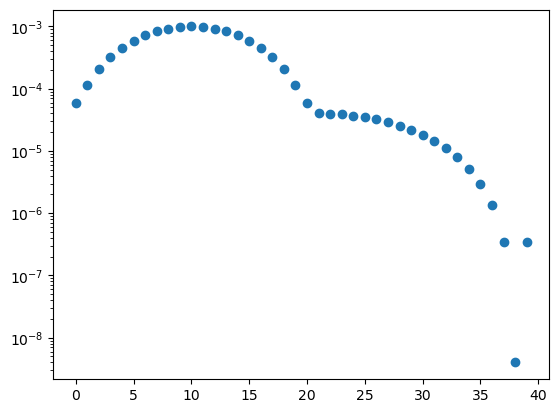

In [148]:
lrs_ = list()
values = list(range(10, 0, -1)) + list(range(0, 20)) + [10]*5 + list(range(10, 0, -1)) + list(range(0, 10)) + list(range(10, 0, -1)) + list(range(0, 10)) + list(range(10, 0, -1))
print(values)
for i in range(40):
    optimizer.step()
    #scheduler.step(values[i])
    scheduler.step()
    #lrs_.append(scheduler.get_last_lr())
    lrs_.append(optimizer.param_groups[0]['lr'])
    
fig, ax = plt.subplots(1)
ax.scatter(range(len(lrs_)), lrs_)
ax.set_yscale('log')

In [151]:
# Init Trainer

BATCH_SIZE = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    logs_per_epoch=4,
    trainloader=trainloader,
    testloader=testloader,
)

Epoch 1 :   0%|          | 0/196 [00:00<?, ?it/s]

[1,    49] loss: 1.946
[1,    98] loss: 1.580
[1,   147] loss: 1.466
[1,   196] loss: 1.394
Train Loss : 1.5964739651096111
Train Accuracy : 42.71 %
Val Loss : 1.3013303935527802
Accuracy of the network on the 10000 test images: 53.72 %


Epoch 2 :   0%|          | 0/196 [00:00<?, ?it/s]

[2,    49] loss: 1.353
[2,    98] loss: 1.306
[2,   147] loss: 1.249
[2,   196] loss: 1.213
Train Loss : 1.2802250148082266
Train Accuracy : 53.79 %
Val Loss : 1.1012936741113664
Accuracy of the network on the 10000 test images: 60.18 %


Epoch 3 :   0%|          | 0/196 [00:00<?, ?it/s]

[3,    49] loss: 1.191
[3,    98] loss: 1.199
[3,   147] loss: 1.169
[3,   196] loss: 1.106
Train Loss : 1.1660794405912867
Train Accuracy : 58.07 %
Val Loss : 1.389212927222252
Accuracy of the network on the 10000 test images: 53.00 %


Epoch 4 :   0%|          | 0/196 [00:00<?, ?it/s]

[4,    49] loss: 1.130
[4,    98] loss: 1.121
[4,   147] loss: 1.087
[4,   196] loss: 1.039
Train Loss : 1.0940707301606938
Train Accuracy : 60.98 %
Val Loss : 1.138514520227909
Accuracy of the network on the 10000 test images: 60.61 %


Epoch 5 :   0%|          | 0/196 [00:00<?, ?it/s]

[5,    49] loss: 1.059
[5,    98] loss: 1.019
[5,   147] loss: 1.005
[5,   196] loss: 0.967
Train Loss : 1.0123492731731765
Train Accuracy : 64.05 %
Val Loss : 1.0396997079253196
Accuracy of the network on the 10000 test images: 64.92 %


Epoch 6 :   0%|          | 0/196 [00:00<?, ?it/s]

[6,    49] loss: 0.965
[6,    98] loss: 0.970
[6,   147] loss: 0.941
[6,   196] loss: 0.907
Train Loss : 0.9457707897740968
Train Accuracy : 66.54 %
Val Loss : 1.0278069540858268
Accuracy of the network on the 10000 test images: 63.76 %


Epoch 7 :   0%|          | 0/196 [00:00<?, ?it/s]

[7,    49] loss: 0.921
[7,    98] loss: 0.859
[7,   147] loss: 0.890
[7,   196] loss: 0.858
Train Loss : 0.8818533061718454
Train Accuracy : 69.09 %
Val Loss : 0.7929083064198494
Accuracy of the network on the 10000 test images: 72.38 %


Epoch 8 :   0%|          | 0/196 [00:00<?, ?it/s]

[8,    49] loss: 0.830
[8,    98] loss: 0.857
[8,   147] loss: 0.817
[8,   196] loss: 0.802
Train Loss : 0.8263911887699243
Train Accuracy : 71.29 %
Val Loss : 0.9334446012973785
Accuracy of the network on the 10000 test images: 69.77 %


Epoch 9 :   0%|          | 0/196 [00:00<?, ?it/s]

[9,    49] loss: 0.779
[9,    98] loss: 0.777
[9,   147] loss: 0.754
[9,   196] loss: 0.750
Train Loss : 0.7652511867333431
Train Accuracy : 73.17 %
Val Loss : 0.9491715013980866
Accuracy of the network on the 10000 test images: 68.06 %


Epoch 10 :   0%|          | 0/196 [00:00<?, ?it/s]

[10,    49] loss: 0.737
[10,    98] loss: 0.713
[10,   147] loss: 0.729
[10,   196] loss: 0.705
Train Loss : 0.7211651190811273
Train Accuracy : 74.77 %
Val Loss : 0.7377957314252853
Accuracy of the network on the 10000 test images: 74.12 %
Finished Training


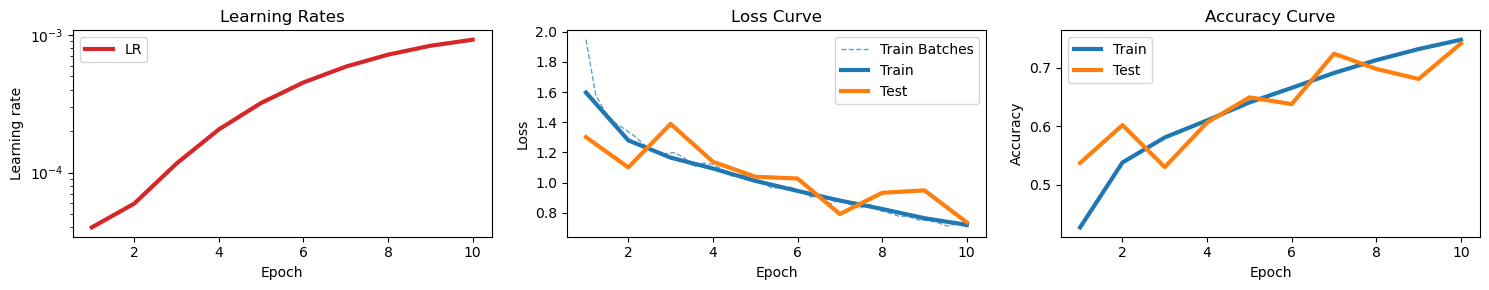

In [152]:
trainer.train(epochs=10, use_gpu=USE_GPU)
trainer.plot()

Epoch 11 :   0%|          | 0/196 [00:00<?, ?it/s]

[11,    49] loss: 0.683
[11,    98] loss: 0.680
[11,   147] loss: 0.670
[11,   196] loss: 0.693
Train Loss : 0.6814224753452807
Train Accuracy : 76.40 %
Val Loss : 0.9596024513244629
Accuracy of the network on the 10000 test images: 68.21 %


Epoch 12 :   0%|          | 0/196 [00:00<?, ?it/s]

[12,    49] loss: 0.673
[12,    98] loss: 0.641
[12,   147] loss: 0.636
[12,   196] loss: 0.642
Train Loss : 0.6479654807825478
Train Accuracy : 77.39 %
Val Loss : 0.7001156151294708
Accuracy of the network on the 10000 test images: 75.79 %


Epoch 13 :   0%|          | 0/196 [00:00<?, ?it/s]

[13,    49] loss: 0.613
[13,    98] loss: 0.606
[13,   147] loss: 0.589
[13,   196] loss: 0.626
Train Loss : 0.6085703275641616
Train Accuracy : 78.76 %
Val Loss : 0.9252279981970787
Accuracy of the network on the 10000 test images: 69.13 %


Epoch 14 :   0%|          | 0/196 [00:00<?, ?it/s]

[14,    49] loss: 0.554
[14,    98] loss: 0.565
[14,   147] loss: 0.568
[14,   196] loss: 0.579
Train Loss : 0.566182979363568
Train Accuracy : 80.22 %
Val Loss : 0.8138324603438377
Accuracy of the network on the 10000 test images: 73.48 %


Epoch 15 :   0%|          | 0/196 [00:00<?, ?it/s]

[15,    49] loss: 0.540
[15,    98] loss: 0.532
[15,   147] loss: 0.539
[15,   196] loss: 0.535
Train Loss : 0.5366426841640959
Train Accuracy : 81.37 %
Val Loss : 0.8298768222332
Accuracy of the network on the 10000 test images: 72.85 %


Epoch 16 :   0%|          | 0/196 [00:00<?, ?it/s]

[16,    49] loss: 0.512
[16,    98] loss: 0.494
[16,   147] loss: 0.497
[16,   196] loss: 0.511
Train Loss : 0.503561329172582
Train Accuracy : 82.35 %
Val Loss : 0.7006936311721802
Accuracy of the network on the 10000 test images: 76.44 %


Epoch 17 :   0%|          | 0/196 [00:00<?, ?it/s]

[17,    49] loss: 0.471
[17,    98] loss: 0.434
[17,   147] loss: 0.470
[17,   196] loss: 0.460
Train Loss : 0.4587836795467503
Train Accuracy : 83.89 %
Val Loss : 0.6290392518043518
Accuracy of the network on the 10000 test images: 78.70 %


Epoch 18 :   0%|          | 0/196 [00:00<?, ?it/s]

[18,    49] loss: 0.432
[18,    98] loss: 0.421
[18,   147] loss: 0.417
[18,   196] loss: 0.423
Train Loss : 0.42309086222429665
Train Accuracy : 85.19 %
Val Loss : 0.49075735807418824
Accuracy of the network on the 10000 test images: 83.37 %


Epoch 19 :   0%|          | 0/196 [00:00<?, ?it/s]

[19,    49] loss: 0.377
[19,    98] loss: 0.393
[19,   147] loss: 0.381
[19,   196] loss: 0.382
Train Loss : 0.3831170749451433
Train Accuracy : 86.53 %
Val Loss : 0.576359611749649
Accuracy of the network on the 10000 test images: 81.18 %


Epoch 20 :   0%|          | 0/196 [00:00<?, ?it/s]

[20,    49] loss: 0.340
[20,    98] loss: 0.335
[20,   147] loss: 0.344
[20,   196] loss: 0.334
Train Loss : 0.338401131864105
Train Accuracy : 88.26 %
Val Loss : 0.464493927359581
Accuracy of the network on the 10000 test images: 84.66 %


Epoch 21 :   0%|          | 0/196 [00:00<?, ?it/s]

[21,    49] loss: 0.306
[21,    98] loss: 0.310
[21,   147] loss: 0.304
[21,   196] loss: 0.302
Train Loss : 0.3055057250419442
Train Accuracy : 89.22 %
Val Loss : 0.42676438614726064
Accuracy of the network on the 10000 test images: 86.01 %


Epoch 22 :   0%|          | 0/196 [00:00<?, ?it/s]

[22,    49] loss: 0.275
[22,    98] loss: 0.288
[22,   147] loss: 0.284
[22,   196] loss: 0.284
Train Loss : 0.2826991158024389
Train Accuracy : 89.97 %
Val Loss : 0.4092063792049885
Accuracy of the network on the 10000 test images: 86.84 %


Epoch 23 :   0%|          | 0/196 [00:00<?, ?it/s]

[23,    49] loss: 0.262
[23,    98] loss: 0.263
[23,   147] loss: 0.258
[23,   196] loss: 0.259
Train Loss : 0.260623567642606
Train Accuracy : 90.95 %
Val Loss : 0.40835731774568557
Accuracy of the network on the 10000 test images: 87.03 %


Epoch 24 :   0%|          | 0/196 [00:00<?, ?it/s]

[24,    49] loss: 0.260
[24,    98] loss: 0.256
[24,   147] loss: 0.261
[24,   196] loss: 0.266
Train Loss : 0.26076169524874004
Train Accuracy : 90.86 %
Val Loss : 0.40744133219122886
Accuracy of the network on the 10000 test images: 86.85 %


Epoch 25 :   0%|          | 0/196 [00:00<?, ?it/s]

[25,    49] loss: 0.258
[25,    98] loss: 0.252
[25,   147] loss: 0.251
[25,   196] loss: 0.254
Train Loss : 0.25351591195378986
Train Accuracy : 91.07 %
Val Loss : 0.4052241504192352
Accuracy of the network on the 10000 test images: 86.89 %


Epoch 26 :   0%|          | 0/196 [00:00<?, ?it/s]

[26,    49] loss: 0.236
[26,    98] loss: 0.250
[26,   147] loss: 0.255
[26,   196] loss: 0.246
Train Loss : 0.24681598427040236
Train Accuracy : 91.28 %
Val Loss : 0.4057755284011364
Accuracy of the network on the 10000 test images: 87.05 %


Epoch 27 :   0%|          | 0/196 [00:00<?, ?it/s]

[27,    49] loss: 0.235
[27,    98] loss: 0.248
[27,   147] loss: 0.242
[27,   196] loss: 0.242
Train Loss : 0.2417762728826124
Train Accuracy : 91.51 %
Val Loss : 0.4120343841612339
Accuracy of the network on the 10000 test images: 86.89 %


Epoch 28 :   0%|          | 0/196 [00:00<?, ?it/s]

[28,    49] loss: 0.240
[28,    98] loss: 0.241
[28,   147] loss: 0.239
[28,   196] loss: 0.239
Train Loss : 0.24005819583425717
Train Accuracy : 91.45 %
Val Loss : 0.42595688104629514
Accuracy of the network on the 10000 test images: 86.74 %


Epoch 29 :   0%|          | 0/196 [00:00<?, ?it/s]

[29,    49] loss: 0.232
[29,    98] loss: 0.229
[29,   147] loss: 0.240
[29,   196] loss: 0.236
Train Loss : 0.23407007206459435
Train Accuracy : 91.71 %
Val Loss : 0.41087978780269624
Accuracy of the network on the 10000 test images: 87.32 %


Epoch 30 :   0%|          | 0/196 [00:00<?, ?it/s]

[30,    49] loss: 0.230
[30,    98] loss: 0.234
[30,   147] loss: 0.230
[30,   196] loss: 0.229
Train Loss : 0.23076886227544474
Train Accuracy : 91.89 %
Val Loss : 0.4100495047867298
Accuracy of the network on the 10000 test images: 87.43 %


Epoch 31 :   0%|          | 0/196 [00:00<?, ?it/s]

[31,    49] loss: 0.232
[31,    98] loss: 0.225
[31,   147] loss: 0.217
[31,   196] loss: 0.232
Train Loss : 0.22621303279789126
Train Accuracy : 92.07 %
Val Loss : 0.4064953163266182
Accuracy of the network on the 10000 test images: 87.57 %


Epoch 32 :   0%|          | 0/196 [00:00<?, ?it/s]

[32,    49] loss: 0.218
[32,    98] loss: 0.218
[32,   147] loss: 0.218
[32,   196] loss: 0.222
Train Loss : 0.21878708564505286
Train Accuracy : 92.21 %
Val Loss : 0.41124567836523057
Accuracy of the network on the 10000 test images: 87.66 %


Epoch 33 :   0%|          | 0/196 [00:00<?, ?it/s]

[33,    49] loss: 0.220
[33,    98] loss: 0.211
[33,   147] loss: 0.212
[33,   196] loss: 0.209
Train Loss : 0.21312765070066161
Train Accuracy : 92.59 %
Val Loss : 0.41346124187111855
Accuracy of the network on the 10000 test images: 87.39 %


Epoch 34 :   0%|          | 0/196 [00:00<?, ?it/s]

[34,    49] loss: 0.214
[34,    98] loss: 0.218
[34,   147] loss: 0.212
[34,   196] loss: 0.209
Train Loss : 0.2134020462328074
Train Accuracy : 92.41 %
Val Loss : 0.4168632410466671
Accuracy of the network on the 10000 test images: 87.44 %


Epoch 35 :   0%|          | 0/196 [00:00<?, ?it/s]

[35,    49] loss: 0.215
[35,    98] loss: 0.206
[35,   147] loss: 0.218
[35,   196] loss: 0.211
Train Loss : 0.2125116787014567
Train Accuracy : 92.53 %
Val Loss : 0.41307912543416025
Accuracy of the network on the 10000 test images: 87.45 %


Epoch 36 :   0%|          | 0/196 [00:00<?, ?it/s]

[36,    49] loss: 0.211
[36,    98] loss: 0.209
[36,   147] loss: 0.201
[36,   196] loss: 0.213
Train Loss : 0.20848385966858085
Train Accuracy : 92.62 %
Val Loss : 0.4129031732678413
Accuracy of the network on the 10000 test images: 87.60 %


Epoch 37 :   0%|          | 0/196 [00:00<?, ?it/s]

[37,    49] loss: 0.213
[37,    98] loss: 0.201
[37,   147] loss: 0.212
[37,   196] loss: 0.208
Train Loss : 0.20856314262717354
Train Accuracy : 92.65 %
Val Loss : 0.4140224814414978
Accuracy of the network on the 10000 test images: 87.52 %


Epoch 38 :   0%|          | 0/196 [00:00<?, ?it/s]

[38,    49] loss: 0.212
[38,    98] loss: 0.197
[38,   147] loss: 0.209
[38,   196] loss: 0.213
Train Loss : 0.20785522711824397
Train Accuracy : 92.64 %
Val Loss : 0.4137575879693031
Accuracy of the network on the 10000 test images: 87.52 %


Epoch 39 :   0%|          | 0/196 [00:00<?, ?it/s]

[39,    49] loss: 0.215
[39,    98] loss: 0.208
[39,   147] loss: 0.208
[39,   196] loss: 0.201
Train Loss : 0.20799624075999065
Train Accuracy : 92.74 %
Val Loss : 0.41220047175884245
Accuracy of the network on the 10000 test images: 87.48 %


Epoch 40 :   0%|          | 0/196 [00:00<?, ?it/s]

[40,    49] loss: 0.211
[40,    98] loss: 0.211
[40,   147] loss: 0.210
[40,   196] loss: 0.203
Train Loss : 0.2087298893198675
Train Accuracy : 92.62 %
Val Loss : 0.4122113101184368
Accuracy of the network on the 10000 test images: 87.41 %
Finished Training


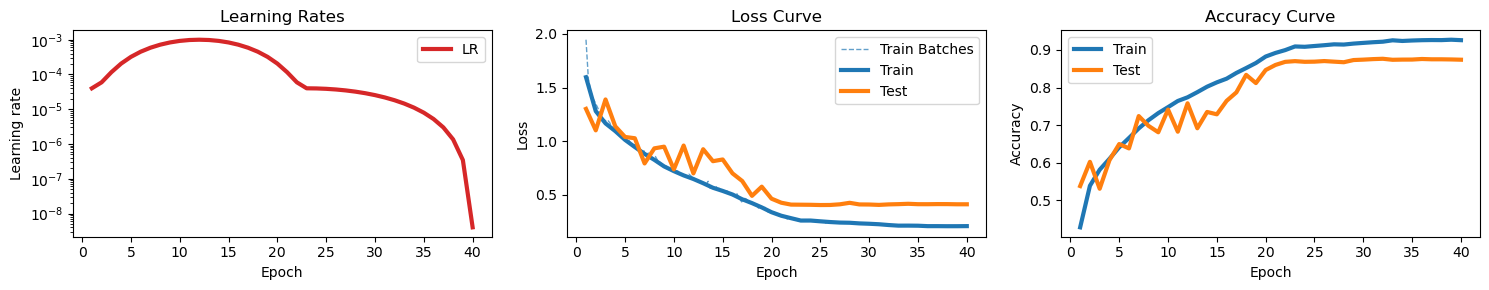

In [153]:
trainer.train(epochs=30, use_gpu=USE_GPU)
trainer.plot()

## Experiment

In [ ]:
class Model2(nn.Module):

  def __init__(self, channels, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
    super(Model2, self).__init__()
	
    self.debug=debug
    
    self.convs = nn.ModuleList(
        nn.Sequential(
            nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], kernel_size=kernel_size),
            #nn.BatchNorm2d(num_features=channels[i+1]),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
        )
        for i in range(n)
    )
    self.img_sizes = find_img_size(initial_img_size=IMG_DIM, depth=n+1, kernel_size=kernel_size, stride=1, pool=2)
    print(f"{self.img_sizes=}")
    
    #self.spaitial_average_pool = nn.AvgPool2d(kernel_size=self.img_sizes[-1])
    self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.linear = nn.Sequential(
        nn.Linear(in_features=channels[-1], out_features=len(CLASSES), bias=False),
    )

  def set_debug(self, debug=True):
    self.debug = debug

  def forward(self, x):

    #x = self.conv1(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv2(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv3(x)
    #if self.debug: print(f"M: {x.shape=}")
    
    for conv in self.convs:
        x = conv(x)
        if self.debug: print(f"M conv: {x.shape=}")
    
    f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"M: {f.shape=}")

    out = self.linear(f)
    if self.debug: print(f"M: {out.shape=}")

    return out